In [8]:
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

# Read input file
data = {}
with open('../data/input/sample_parameters.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        data[row[0]] = float(row[1])
    print(data)

# Assign variables
A_lambda = math.log(2) / data['t_1/2_A (hr)']
B_lambda = math.log(2) / data['t_1/2_B (hr)']
NA0 = data['NA0']
NB0 = data['NB0']
NC0 = data['NC0']
delta = data['delta_t']
tfinal = data['t_final (hr)']

{'t_1/2_A (hr)': 1.97, 't_1/2_B (hr)': 9.91, 'NA0': 100.0, 'NB0': 0.0, 'NC0': 0.0, 'delta_t': 1.0, 't_final (hr)': 50.0}


## 1. Analytical Solution

In [9]:
# Analytical Solution
t = np.arange(0, tfinal + delta, delta)

def analytical_solution(time):
    NA = NA0 * np.exp(-A_lambda * time)
    NB = (NA0 * A_lambda / (B_lambda - A_lambda)) * (np.exp(-A_lambda * time) - np.exp(-B_lambda * time))
    NC = NA0 - NA - NB
    return NA, NB, NC

NA_as, NB_as, NC_as = analytical_solution(t)
total_as = NA_as + NB_as + NC_as

## 2. Numerical Solution using Explicit Euler Method

In [10]:
# Numerical Solution
def numerical_solution(interval):
    t = np.arange(0, tfinal + interval, interval)
    NA = [NA0]
    NB = [NB0]
    NC = [NC0]
    total = [NA0 + NB0 + NC0]
    for i in range(1, len(t)):
        NA_value = NA[i - 1] - (A_lambda * NA[i - 1] * interval)
        NA.append(NA_value)

        NB_value = NB[i - 1] + interval * ((A_lambda * NA[i - 1]) - (B_lambda * NB[i - 1]))
        NB.append(NB_value)

        NC_value = NC[i - 1] + B_lambda * NB[i - 1] * interval
        NC.append(NC_value)
        
        total.append(NA[i] + NB[i] + NC[i])
    return NA, NB, NC, total, t

NA_ns, NB_ns, NC_ns, total_ns, t_ns = numerical_solution(delta)

## 3. Comparison and Visualization

In [11]:
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["STIX Two Text"],  # Matches LaTeX's Computer Modern font: for neatness in the report
    "mathtext.fontset": "stix"  # Ensures math symbols match
})

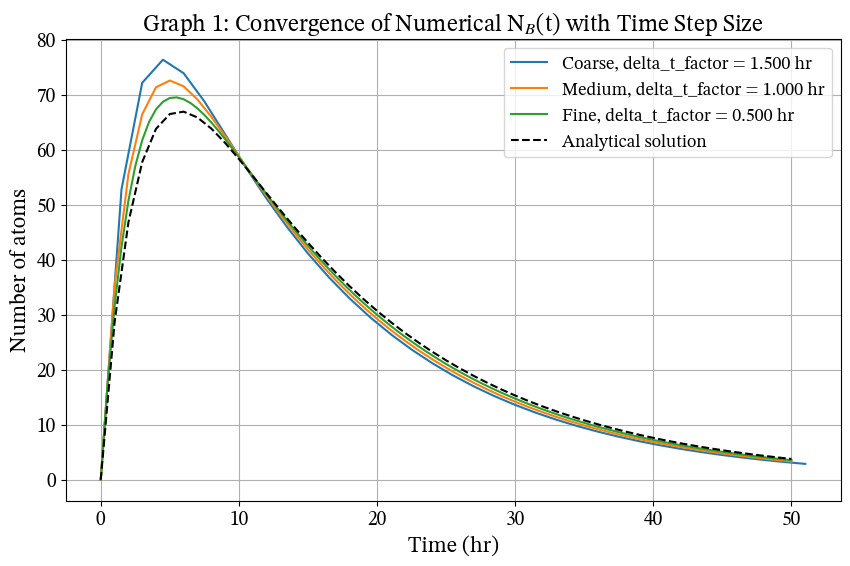

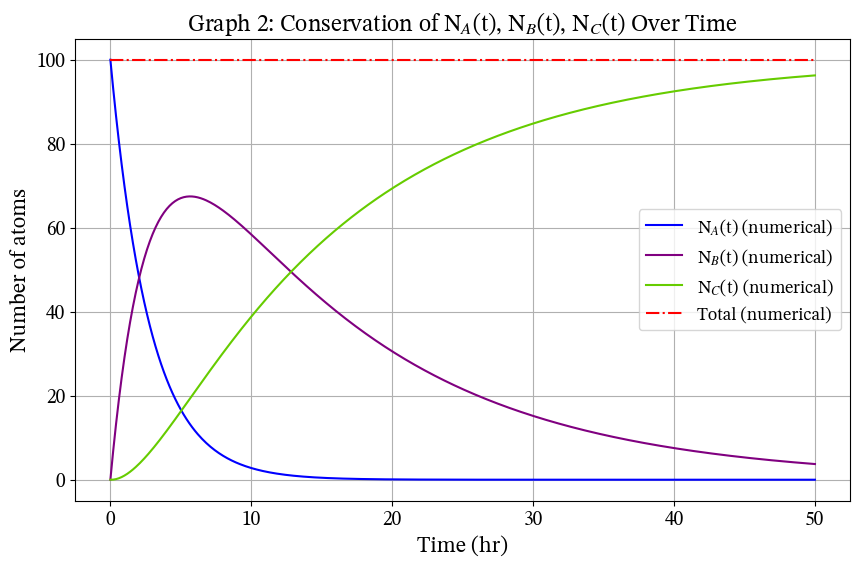

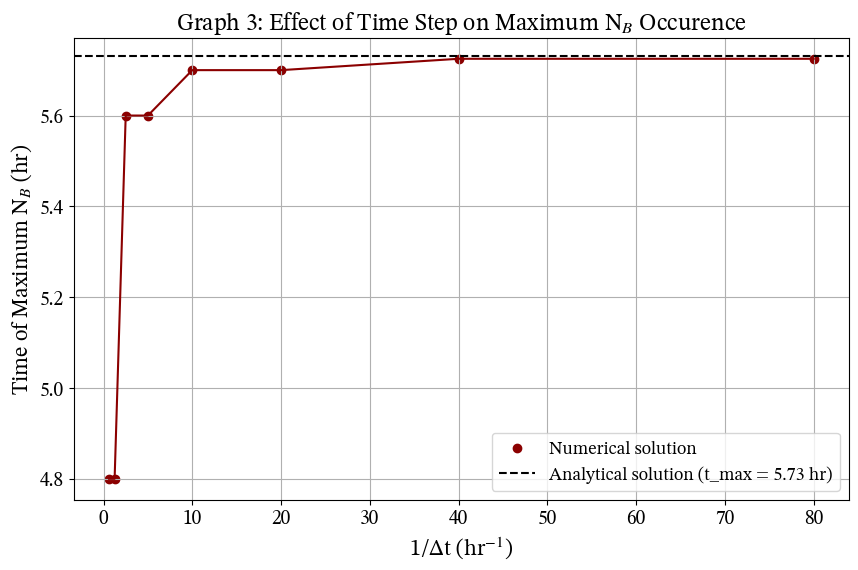

In [12]:
# Problem 1: Accuracy of numerical NB(t) for three different Δts
smoothness_results = []
delta_values = {"Coarse": delta * 1.5, "Medium": delta * 1, "Fine": delta / 2}
for key, delta_val in delta_values.items():
    NA_ns_fine, NB_ns_fine, NC_ns_fine, total_fine, t_fine = numerical_solution(delta_val)
    smoothness_results.append((key, delta_val, NB_ns_fine, t_fine))

# Plot Problem 1
plt.figure(figsize=(10, 6))
for label, delta_val, NB_fine, t_fine in smoothness_results:
    plt.plot(t_fine, NB_fine, label=f"{label}, delta_t_factor = {delta_val:.3f} hr")
plt.plot(t, NB_as, 'k--', label="Analytical solution")
plt.xlabel("Time (hr)", fontsize=16)
plt.ylabel("Number of atoms", fontsize=16)
plt.title("Graph 1: Convergence of Numerical N$_{B}$(t) with Time Step Size", fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=13)
plt.grid(True)
plt.show()

# Problem 2: Numeric NA(t), NB(t), NC(t) and Total

NA_ns_reliable, NB_ns_reliable, NC_ns_reliable, total_ns_reliable, t_reliable = numerical_solution(0.1) # Note: Reliable Solution Δt = 0.1 hr <- found from trial and error to be smooth enough to reflect solutions properly

# Plot Problem 2
plt.figure(figsize=(10, 6))
plt.plot(t_reliable, NA_ns_reliable, color='blue', label="N$_{A}$(t) (numerical)")
plt.plot(t_reliable, NB_ns_reliable, color='purple', label="N$_{B}$(t) (numerical)")
plt.plot(t_reliable, NC_ns_reliable, color='#66cc00', label="N$_{C}$(t) (numerical)")
plt.plot(t_reliable, total_ns_reliable, color ='red', linestyle='-.', label="Total (numerical)")
plt.xlabel("Time (hr)", fontsize=16)
plt.ylabel("Number of atoms", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Graph 2: Conservation of N$_{A}$(t), N$_{B}$(t), N$_{C}$(t) Over Time", fontsize=17)
plt.legend(fontsize=13)
plt.grid(True)
plt.show()

# Problem 3: t_max of NB vs. 1/Δt
def NB_max(interval):
    max_NB = []
    inv_interval = []
    step = interval / 80 
    for _ in range(8): # Note: 80 and 8 were chosen arbitrarily but you can choose a finer starting point (e.g. step = interval/100) and have more steps (e.g. range(10))
        inv_interval.append(1 / step)
        NA, NB, NC, total, t_step = numerical_solution(step)
        max_NB.append(t_step[NB.index(max(NB))])
        step *= 2
    return inv_interval, max_NB


inv_interval, max_NB = NB_max(delta)
t_max_analytical = np.log(A_lambda / B_lambda) / (A_lambda - B_lambda)

# Plot Problem 3
plt.figure(figsize=(10, 6))
plt.scatter(inv_interval, max_NB, color='#8b0000', marker='o', label="Numerical solution")
plt.plot(inv_interval, max_NB, color='#8b0000', linestyle='-')
plt.axhline(y=t_max_analytical, color='black', linestyle='--', label=f'Analytical solution (t_max = {t_max_analytical:.2f} hr)')
plt.xlabel("1/Δt (hr$^{-1}$)", fontsize=16)
plt.ylabel("Time of Maximum N$_{B}$ (hr)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Graph 3: Effect of Time Step on Maximum N$_{B}$ Occurence", fontsize=17)
plt.legend(fontsize=13)
plt.grid(True)
plt.show()

In [13]:
# Write output file
with open('../data/output/simulation_results.csv', mode='w', newline='') as output:
    filewriter = csv.writer(output, delimiter=',', lineterminator='\n', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(["A_lambda", A_lambda])
    filewriter.writerow(["B_lambda", B_lambda])
    filewriter.writerow(["NA0", NA0])
    filewriter.writerow(["NB0", NB0])
    filewriter.writerow(["NC0", NC0])
    filewriter.writerow(["delta_t", delta])
    filewriter.writerow(["tfinal (hr)", tfinal])
    filewriter.writerow(["t"] + list(t))
    filewriter.writerow(["NA_analytical_soln"] + list(NA_as))
    filewriter.writerow(["NB_analytical_soln"] + list(NB_as))
    filewriter.writerow(["NC_analytical_soln"] + list(NC_as))
    filewriter.writerow(["total_analytical_soln"] + list(total_as))
    filewriter.writerow(["NA_numerical_soln"] + list(NA_ns))
    filewriter.writerow(["NB_numerical_soln"] + list(NB_ns))
    filewriter.writerow(["NC_numerical_soln"] + list(NC_ns))
    filewriter.writerow(["total_numerical_soln"] + list(total_ns))
    for label, delta_val, NB_fine, t_fine in smoothness_results:
        filewriter.writerow([f"{label}, delta_t_factor = {delta_val:.4f}"] + list(NB_fine))
    filewriter.writerow(["max_NB"] + list(max_NB))
    filewriter.writerow(["inverse_interval"] + list(inv_interval))

In [14]:
# Read and verify output (optional)
csv_arr = []
with open('../data/output/simulation_results.csv', mode='r') as output:
    filereader = csv.reader(output)
    for row in filereader:
        csv_arr.append(row)
print(f"Output file has {len(csv_arr)} rows") # Note: Should be 21

Output file has 21 rows
